## BRAIN MRI PROJECT

Big Data Project by Mikel Prieto Echegaray & Álvaro Resano Redín

The main objective of this notebook is to perform a CNN model in order to be able to differenciate between several brain tumours.

We have obtained the dataset from Kaggle, url: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset

There are 3 types of tumours: glioma, meningioma and pituitary.

Each step of this study will be explained on the notebook.

# 1. Load data

First, we load the data from the url and we set the image size, all the images of the dataset should have this size but we will resize them just in case there is any image with different size.

In [1]:
import kagglehub
import os

dataset_path = kagglehub.dataset_download("mohammadhossein77/brain-tumors-dataset")
dataset_path = os.path.join(dataset_path, "Data") #Enter in the folder Data


IMG_SIZE = (224, 224)

Now we transform the data to a PyTorch Dataset

In [2]:
import torch 
import numpy as np
import cv2
from torch.utils.data import DataLoader, Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["Normal", "Tumor/glioma_tumor", "Tumor/meningioma_tumor", "Tumor/pituitary_tumor"]
        self.images = []
        self.labels = []

        for label, category in enumerate(self.classes):
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)
        label = self.labels[idx]
        return img, label


Not only have we transformed the images to PyTorch, but also:
- resized all images to 224x224
- normalized values to 255
- changed format from (height, width, channel) to (channel, height, width)

We load the dataset

In [3]:
brain_dataset = BrainTumorDataset(dataset_path)

**Count of images per class**

In [17]:
import matplotlib.pyplot as plt

def count_of_classes(brain_dataset):
    counts = [brain_dataset.labels.count(i) for i in range(len(brain_dataset.classes))]
    plt.bar(brain_dataset.classes, counts, color='skyblue')
    plt.xticks(rotation=20, ha="right")
    plt.title("Images Distribution per Class")
    plt.ylabel("Amount of images")
    plt.tight_layout()
    plt.show()

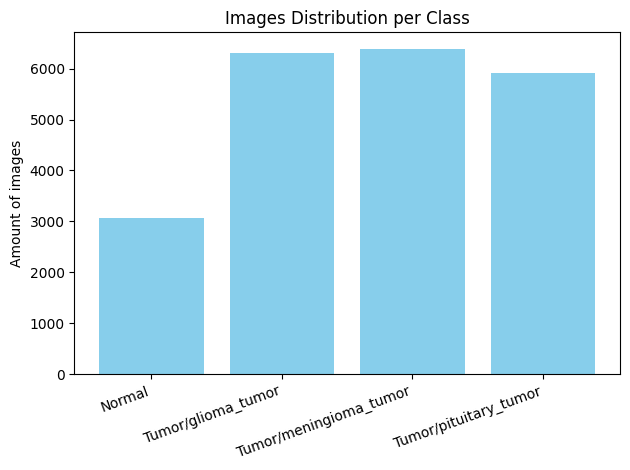

In [18]:
count_of_classes(brain_dataset)

**Random Samples Plot**

In [19]:
def show_random_samples(dataset, classes):
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
    for class_idx, class_name in enumerate(classes):
        class_indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
        random_samples = np.random.choice(class_indices, size=5, replace=False)
        for j, idx in enumerate(random_samples):
            img, _ = dataset[idx]
            img = np.transpose(img.numpy(), (1, 2, 0))
            axes[class_idx, j].imshow(img)
            axes[class_idx, j].axis('off')
            if j == 0:
                axes[class_idx, j].set_title(class_name)
    plt.show()

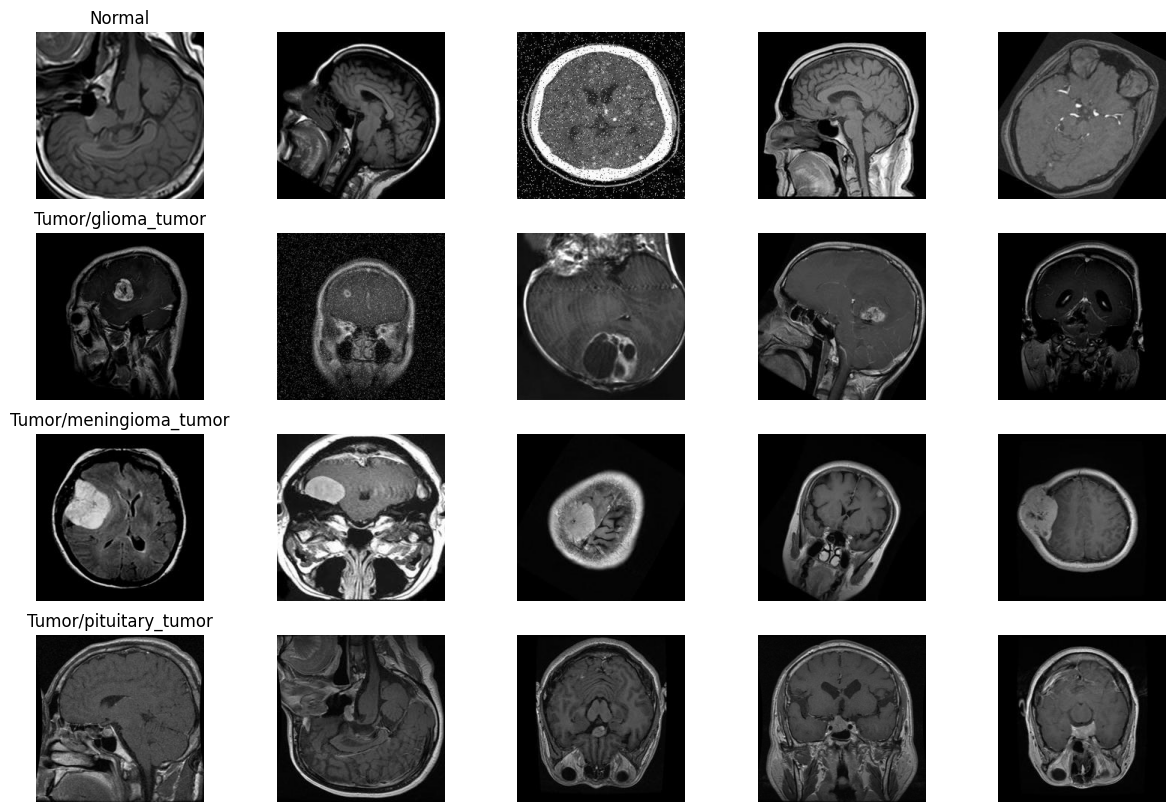

In [20]:
show_random_samples(brain_dataset, brain_dataset.classes)

# 2. Split data in train and test

First, we will set a seed for random functions

In [4]:
import random 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

We split data in 80% train and 20% test.
We have stratified the data in order to guarantee the proportion between classes remains 

In [5]:
from sklearn.model_selection import train_test_split

brain_dataset = BrainTumorDataset(dataset_path)

labels = brain_dataset.labels

train_indices, test_indices = train_test_split(
    list(range(len(brain_dataset))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(brain_dataset, train_indices)
test_dataset = torch.utils.data.Subset(brain_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

We will use cuda if it is available instead of the cpu

In [6]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()


# 3. CNN Arquitecture

The next step is to create the Convolutional Neural Network, with 3 convolutional layers, max pooling and 2 fully connected layers. We have also decided to use Dropout for regularization.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 4. Model Training

Now we need to train our model in order to learn from our images and hwo the different tumours are shown on RMIs.

This is the train function we will be performing

In [36]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    history = {'loss': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        history['loss'].append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return history

First, we create an instance of our model and change it to GPU or CPU.

We use CrossEntropyLoss for multiclass classification.

We use Adam as optimizer with learning rate equal to 0.001.

Finalyy, we train the model 10 epochs and we save the Loss.

In [26]:
import torch.optim as optim

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.9002
Epoch 2/10, Loss: 0.5243
Epoch 3/10, Loss: 0.3152
Epoch 4/10, Loss: 0.2176
Epoch 5/10, Loss: 0.1425
Epoch 6/10, Loss: 0.1056
Epoch 7/10, Loss: 0.0887
Epoch 8/10, Loss: 0.0700
Epoch 9/10, Loss: 0.0638
Epoch 10/10, Loss: 0.0503


**Training Loss Plot**

In [27]:
import matplotlib.pyplot as plt

def plot_training_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(history['loss']) + 1), history['loss'], marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.grid()
    plt.show()

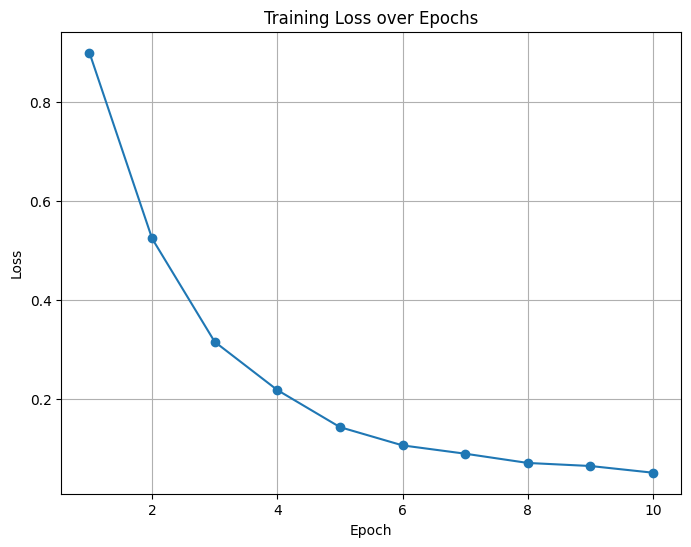

In [28]:
plot_training_loss(history)

The conclusion we obtain based on the Elbow Rule is that it is not necessary to perform 10 epochs for our training, 5 are enough.

**Final Model**

In [37]:
final_model = CNNModel().to(device)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

train_model(final_model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.7958
Epoch 2/5, Loss: 0.3824
Epoch 3/5, Loss: 0.1782
Epoch 4/5, Loss: 0.0915
Epoch 5/5, Loss: 0.0679


{'loss': [0.7957863478862931,
  0.3823700419513722,
  0.17822634990626046,
  0.0914542137673537,
  0.06792313308032775]}

**Confusion Matrix Plot**

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion_Matrix")
    plt.show()

Epoch 1/5, Loss: 1.3837
Epoch 2/5, Loss: 1.3837
Epoch 3/5, Loss: 1.3838
Epoch 4/5, Loss: 1.3837
Epoch 5/5, Loss: 1.3837


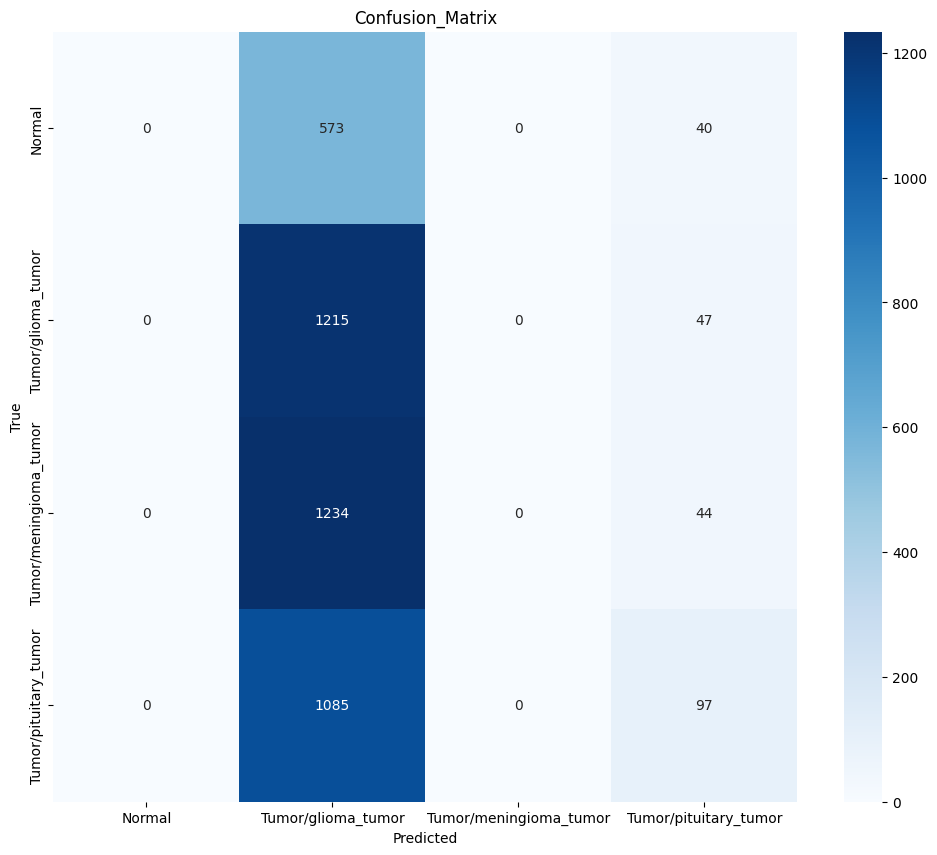

In [33]:
plot_confusion_matrix(final_model, test_loader, brain_dataset.classes)

# 5. Model Evaluation

On this last part of our notebook, we evaluate how our model has performed using standard classification metrics.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [13]:
evaluate_model(final_model, test_loader)

Accuracy: 94.39%
Precision: 0.9438
Recall: 0.9439
F1 Score: 0.9438


**ROC Curves plot**

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

def plot_roc_curves(model, test_loader, classes):
    model.eval()
    y_true, y_score = [], []
    num_classes = len(classes)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities)
    
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    plt.figure(figsize=(10, 8))
    colors = itertools.cycle(["blue", "red", "green", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"])
    
    for i, color in zip(range(num_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f"{classes[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 0.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by classes")
    plt.legend(loc="lower right")
    plt.show()

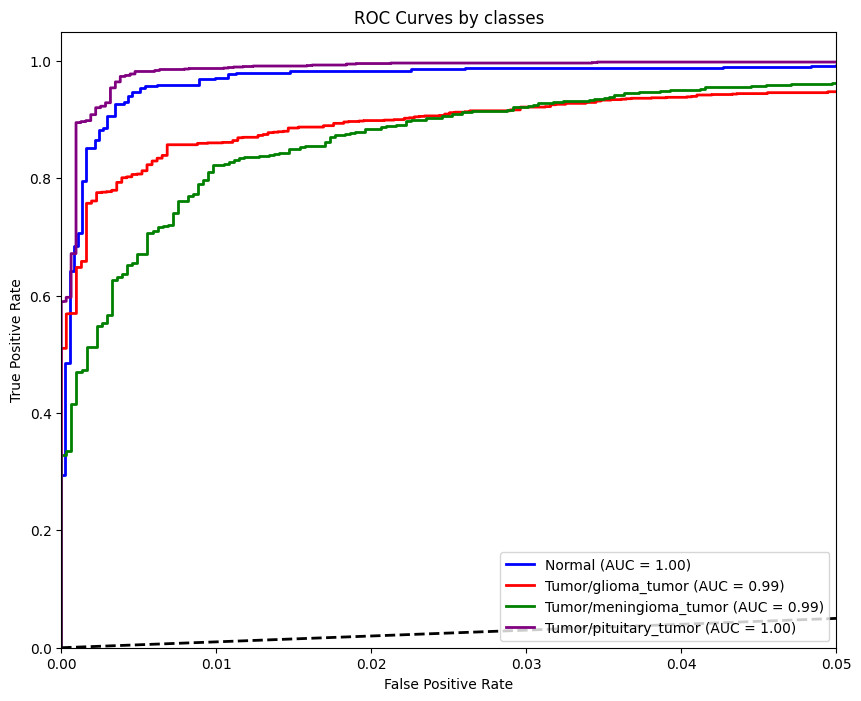

In [25]:
plot_roc_curves(final_model, test_loader, brain_dataset.classes)